# Biblography 

### An Introduction to Probabilistic Spiking Neural Networks: [[1]](https://arxiv.org/pdf/1910.01059.pdf)

### USPS dataset: [[2]](https://www.kaggle.com/bistaumanga/usps-dataset)

### Spatio-temporal correlations and visual signalling in a complete neuronal population: [[3]](https://www.nature.com/articles/nature07140)

# Loading the required packages

In [218]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

# USPS dayaset

> USPS dataset, "usps.h5", is a _h5_ formated file and we us "h5py" package to load it. We assume it is saved in the current directory. Here, we load the train and test sets with their corresponding labels.

In [3]:
import h5py
with h5py.File('usps.h5', 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

# An example

Label: 7

Picture:


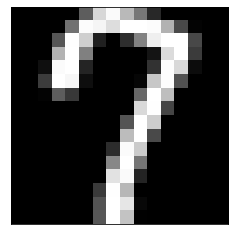

In [1394]:
print(f"Label: {y_tr[3]}")
print()
print("Picture:")
plt.imshow(X_tr[3,:].reshape(16,16), interpolation='nearest', cmap='gray')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.show()

# Ones and sevens

### 500 training, 125 testing

> To test the accuracy of the following SNN classifier, the train and test set restricts to ones and sevens. In addition, sinilar to [[1]](https://arxiv.org/pdf/1910.01059.pdf), we use the first 500 cases from train set and 125 cases from test set. These choices allow us to compare the final accuracy with the reported one in [[1]](https://arxiv.org/pdf/1910.01059.pdf).

In [7]:
# Restricted train set
y2_tr = y_tr[(y_tr == 1) | (y_tr == 7)][:500]
# Restricted train labels
X2_tr = X_tr[(y_tr == 1) | (y_tr == 7),:][:500]
# Restricted test set
y2_te = y_te[(y_te == 1) | (y_te == 7)][:125]
# Restricted test labels
X2_te = X_te[(y_te == 1) | (y_te == 7),:][:125]

# Global parameters

In [1253]:
# Number of output neoruns
neuron_numbers = 2
# Number of basis in forward filter
K = 12
# Spikes maximum steps
T = 32
# Rate encoding in Hz
Freq = 3
# Train set size
train_size = X2_tr.shape[0]
# Number of pixels in an image
image_size = X2_tr.shape[1]
# Test set size
test_size = X2_te.shape[0]

# Rate encoding

> Before directly clamping the images to the network inputs, we encode the USPS dataset by using  _rate encoding_, "Freq", in the above cell. 

> Each gray pixel is converted into an input spiking signal by generating an independent identically distributed (i.i.d.) Bernoulli vector of T samples, with the spiking probability takes as proportional to the pixel intensity. Besides, the probability is limited to be between zero and 0.5.

In [538]:
# For each 16 x 16 image, we need a 256 x T array to fill it with an iid sampled vector
trainset = np.zeros((train_size, image_size, T))
train_y = np.zeros((neuron_numbers, train_size, T))

for image_index in range(train_size):
    ############################################################
    #
    #    Train set lables
    #
    # Note: 1) We fill the true labels with a frequency of spikes
    #       denotes as Freq in Hz
    #       2) False labels are zero arrays
    if y2_tr[image_index] == 1:
        train_y[0, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
    else:
        train_y[1, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
    ############################################################
    #
    #    Train set images
    #    
    image = X2_tr[image_index,:]    
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        # Note: Image intesity is divided by 2 to keep the probability in [0, 0.5]
        trainset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)        
        
testset = np.zeros((test_size, image_size, T))
for image_index in range(test_size):
    ############################################################
    #
    #    Test set images
    #   
    image = X2_te[image_index,:]
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        # Note: Image intesity is divided by 2 to keep the probability in [0, 0.5]
        testset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)            

# Defining functions

In [ ]:
def sigmoid(x):
    return np.array(1/(1+np.exp(-x)))

def convolution(f_t, g_t):
    ''' See eq. (4) below
    '''
    return np.dot(f_t, g_t[::-1])

# Filter Kernels

### Raised Cosine Kernels
> We use the cosin basis that are represented in [[3]
](https://www.nature.com/articles/nature07140).

> Note that the time domian is in logarithmic scale. So, "this basis allows for the representation of fine temporal structure near the time of a spike and coarser/smoother dependency at later times"[[3]](https://www.nature.com/articles/nature07140)

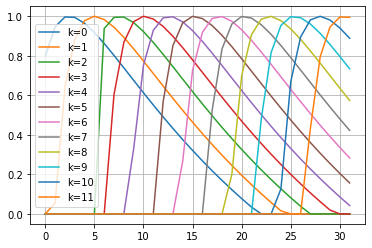

In [1254]:
cosin_basis = np.zeros((K, T))
for k in range(K):    
    cosin_basis[k, :] = np.cos(np.log(-k/2 + 7*np.pi/6 + (2*np.arange(0, T)-T)*np.pi/(T)))
    # Negative values replaces by zero
    cosin_basis[k, cosin_basis[k, :] < 0 ] = 0    
    # We make sure the support of the filter is one and only one segment
    if k > 1 :
        cosin_basis[k, :(k+4)] = 0
    # Make sure there is non Nan in the array and replace them
    # by zero
    cosin_basis[k, :] = np.nan_to_num(cosin_basis[k, :])
    # Plot the curve 
    plt.plot(cosin_basis[k, :], label=f"k={k}")
    
plt.grid()
plt.legend()
plt.show()

# Convolution of two basis: Example

> The convolutions of a sequence of spikes with repect to two positive cosine basis and one negative cosine basis are shown in the following. 

> The negative cosine basis can be used for feedback spikes.

Convolution of K = 1, 4.3458
Convolution of K = 8, 3.8220


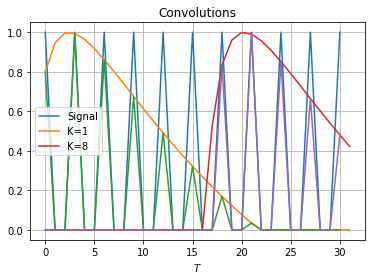

Convolution of K = 5, -4.2605


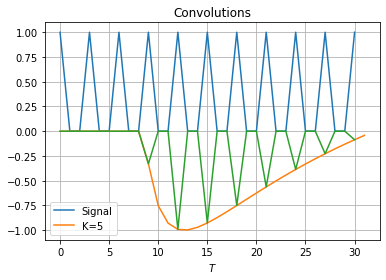

In [1255]:
b = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
print(f"Convolution of K = 1, {np.sum(cosin_basis[0,:b.shape[0]]*b[::-1]):.4f}")
print(f"Convolution of K = 8, {np.sum(cosin_basis[7,:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(cosin_basis[0,:], label = "K=1")    
plt.plot(cosin_basis[0,:b.shape[0]]*b[::-1])

plt.plot(cosin_basis[7,:], label = "K=8")    
plt.plot(cosin_basis[7,:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

print(f"Convolution of K = 5, {np.sum(-cosin_basis[4,:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(-cosin_basis[4,:], label = "K=5")    
plt.plot(-cosin_basis[4,:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

# Feedback exponential Kernel

> An exponential feedback filter, as it was explained in [[1]](https://arxiv.org/pdf/1910.01059.pdf),  controls the immediate capability of spiking of a neuron, after the last one.  

> Mathematically, it defines as $-\exp(-t/t_m)$, where $t_m$ denotes the scale length for exponential decrease in the time domain. Here, we take $t_m = T/8$, where $T = 32$ is the maximum time step in the simulation.

> Finally, the filter plot and its convolutions with repect to a sequence of spikes are depicted.

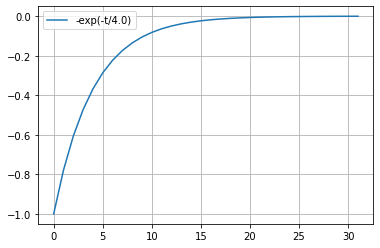

Convolution , -1.8948


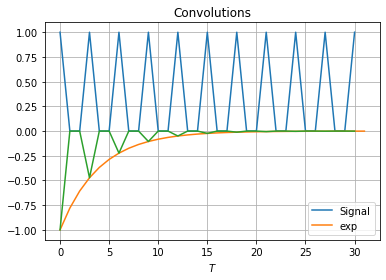

In [1256]:
# Time scale
T_m = T/8
# Filter's array
exp_basis = np.zeros(T)
for t in range(T):
    exp_basis[t] = -np.exp(-t/T_m)

# Plot the filter
plt.plot(exp_basis, label=f"-exp(-t/{T_m:.1f})")    
plt.grid()
plt.legend()
plt.show()    

# Plot the convolution
b = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
print(f"Convolution , {np.sum(exp_basis[:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(exp_basis, label = "exp")    
plt.plot(exp_basis[:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

# NN topology: No Hidden Layer

> using the mathemaical results in [[1]](https://arxiv.org/pdf/1910.01059.pdf), here we list all the relations that we shall use in the simulation. Note that numbers next to each equation can be found in the comment sections of the code.

## Memberane potential, $u_{i, t}$ at time $t$:

## $u_{i, t} = \sum_{j \in \mathcal{P_j}} \omega_{j, i} \overrightarrow{s}_{j, t-1} + \omega_i \overleftarrow{s}_{i, t-1} + \gamma_i  \;\;\;\;\;\;\;\;\;\;\;\;\;$ (1)         

## where 
1. $\mathcal{P_j}$ is the set of pre-synaptic inputs for the neuron $i$.
2. $\omega_{j, i}$  is the feedforward weight for input $j$ to the neuron $i$.
3. $\omega_i$ is the feedback weight for the neuron $i$.
4. $\gamma_i$ is the bias parameter.
5. $\overrightarrow{s}_{j, t-1} = a_t * s_{j, t-1}$ for feedforward filter basis $a_t$ (2).
6. $\overleftarrow{s}_{i, t-1} = b_t * s_{j, t-1}$ for feedback filter basis $b_t$ (3).
7. $f_t * g_t = \sum_{\delta \ge 0} f_{\delta} g_{t - \delta}$ is a convolution operator (4).


# Learning by Maximum log-likelihood estimation ([1])

### The gradiant of the log-liklihood w.r.t. parameter $\boldsymbol{\theta_i}$ for neuron $i$
$\newcommand{\ora}[1]{\overrightarrow{#1}}$
$\newcommand{\ola}[1]{\overleftarrow{#1}}$
### $\nabla_{\boldsymbol{\theta_i}} \mathcal{L}_{\boldsymbol{S}\le T}(\boldsymbol{\theta}) = \sum_{t=0}^{T} \nabla_{\boldsymbol{\theta_i}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1})  \;\;\;\;\;\;\;\;\;\;\;\;\;$ (5)

#### Note: The individual entries for each time step $t$ contributes as the summand of the sum.

### The gradiant w.r.t. weights

### $\nabla_{\gamma_i} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = s_{i,t} - \sigma(u_{i, t}),  \;\;\;\;\;\;\;\;\;\;\;\;\;$(6)

### $\nabla_{w_{i,j}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = \ora{s}_{j, t-1}(s_{i,t} - \sigma(u_{i, t})),   \;\;\;\;\;\;\;\;\;\;\;\;\;$(7)

### $\nabla_{w_{i}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = \ola{s}_{j, t-1}(s_{i,t} - \sigma(u_{i, t})),   \;\;\;\;\;\;\;\;\;\;\;\;\;$(8)

### where $\sigma(x) = 1/(1+\exp(-x))$


# Neuron Object:
> This class stores internal states such as previous memberance potentials. Calling _output_ method for time $t$, moves the internal state one step forwrd. Similarly, calling gradiant method returns the MLE gradiant at time $t$ while moves the internal state one step forwrd.

> The _update_ method implements a fast version of SGD algorithm and updates the neuron weigths. By using [np.einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) method, the following code provides a simple interface to switch to other architectures. For instance, [pytorch](https://pytorch.org/) implements the same function and can exploits available GPUs for faster multiplications. Therefore, the code can be easily ported to that architecture.

In [1342]:
class Neuron:
    def __init__(self, image_size, K, T, 
                 forwrd_basis, feedback_basis,
                 prob_threshold = .5):
        ''' Create a new instance of a Neuron object.
        
            image_size (integer): The size of an image array
            K (integer): Number of forward filter basis.
            T (integer): Maximum number of time steps
            forwrd_basis (np array): Pre-synoptic filter basis
            feedback_basis (np array): Post-synoptic filter basis
            prob_threshold (default 0.5): 
                 The threshold above which the neuron
                 fires and spike.                                   
        '''
        self.image_size = image_size
        self.K = K
        self.T = T
        self.prob_threshold = prob_threshold
        
        if len(feedback_basis.shape) == 1:
            self.feedbacks_K = 1
        else:
            self.feedbacks_K = K
        
        # Initialise weigths by sampling from Uniform(-1, 1)
        self.synaptic_ws = np.random.uniform(-1, 1, (image_size,  K))
        self.feedback_ws = np.random.uniform(-1, 1,  self.feedbacks_K)                    
        self.gamma = np.random.uniform(-1, 1)
        # Store filter basis
        self.forwrd_basis = forwrd_basis
        self.feedback_basis = feedback_basis
        # The inversion that is required for the convolusion is
        # time consuming in each SGD step. So, we construct an inversed
        # tensor now, and call it later, to achieve better performance 
        self.fast_forward_basis = np.zeros((K, T, T))
        for k in range(K):
            for t in range(1, T+1):
                segment = forwrd_basis[k, :t]
                self.fast_forward_basis[k, t-1, :t] = segment[::-1]
        #############################################
        # Internal states      
        #
        
        # This matrix stores $s_{j, t-1}$ in eq. (2)
        self.s_forward_t_1_s = np.zeros((image_size, K))
        # This value/array stores $s_{j, t-1}$ in eq. (3)
        if self.feedbacks_K == 1:
            self.s_feedback_t_1_s = np.zeros(1)        
        else:
            self.s_feedback_t_1_s = np.zeros(self.feedbacks_K) 
        # Previous spikes             
        self.previous_spikes = np.zeros(self.T +1)
        
        
           
    def output(self, image, t):
        ''' This method returns the membrane potential
            and changes the internal states of the neuron.
            
            Note: This method is for demonstration only. No performance
                  consideration is included here.
            
            image (np array (image_size x T)): The encoded image matrix
            t (integer): Time is zero based, so, t referes to the current
                         time and must start from 1.                         
        '''        
        # loop over filter basis
        for k in range(self.K):
            # loop over the pixels
            for j in range(self.image_size):
                spikes = image[j, :t]                    
                # contribution from j input                                          
                # Convolution, see eq. (2)
                self.s_forward_t_1_s[j, k] = convolution(self.forwrd_basis[k, :t], spikes)
                # Check the validity of the outputs
                if np.isnan(self.s_forward_t_1_s[j, k]):
                    print(f"NAN s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
                if np.isinf(self.s_forward_t_1_s[j, k]):
                    print(f"Inf s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
                    
            # At time t = 1, we take the previous spike as zero
            # So, the feedback is zero too.
            if self.feedbacks_K > 1:
                # Feedback contribution
                # The array previous_spikes contains the history of pulses that
                # has been emitted from the neorun.
                # Convolution, see eq. (3)
                self.s_feedback_t_1_s[k] = convolution(self.feedback_basis[k, :t], self.previous_spikes[:t])  
        
        # At time t = 1, we take the previous spike as zero
        # So, the feedback is zero too.                        
        if self.feedbacks_K ==1:
            # Feedback contribution
            # The array previous_spikes contains the history of pulses that
            # has been emitted from the neorun.
            # Convolution, see eq. (1) 
            self.s_feedback_t_1_s = convolution(self.feedback_basis[:t], self.previous_spikes[:t]) 
            
        # Calculating membrane potential
        # This is the sum of contributions from
        # inputes, feedback and bias.
        # See eq. (1)
        u_i = (
               np.sum(self.synaptic_ws*self.s_forward_t_1_s)
             + np.sum(self.feedback_ws*self.s_feedback_t_1_s)                 
             + self.gamma
        )
        # Check the validity of u_i
        if np.isinf(u_i):
            print(f"Inf u_i i={self.i}")
            raise ValueError 
        
        # According to the value of sigmoid(u_i) and spike threshold,
        # the neuron fires. We store this internal state in  previous_spikes array.
        # In the next time step, we use it to find the convolution of the feedback signal.
        self.previous_spikes[t] = 1 if sigmoid(u_i) >= self.prob_threshold else 0
           
        return u_i
    
    def gradiant(self, s_i, image, t):
        ''' The gradiant method moves the internal state
            one step forward, while it returns the gradiants
            with respect the weights
            
            s_i (0 or 1): the true label at time t.
            image (np array (image_size x T)): The encoded image matrix
            t (integer): Time is zero based, so, t referes to the current
                         time and must start from 1. 
        '''
        # Eq. (6)        
        diff = s_i - sigmoid(self.output(image, t))        
        g_bias = diff            
        # Eq. (7)
        g_synaptic_ws = self.s_forward_t_1_s*diff        
        # Eq. (8)
        g_feedback_ws = self.s_feedback_t_1_s*diff
        
        return (g_bias, g_synaptic_ws, g_feedback_ws)
    
    def memb(self, image):
        ''' Returns neorun's membrane potential for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        self.previous_spikes = np.zeros(self.T +1)
        return np.array([self.output(image, t) for t in range(1, self.T)])
    
    def probs(self, image): 
        ''' Returns neorun's probability of firing an spike for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return sigmoid(self.memb(image))
    
    def spikes(self, image):
        ''' Returns neorun's spikes for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return np.where(self.probs(image) >= self.prob_threshold, 1, 0)
    
    def output_f(self, image):
        ''' Fast version of the output method.
            it returns an np array size T of u_i
        ''' 
        s_forward_T = np.einsum('ijk, lk -> jli', self.fast_forward_basis, image)
        forward_T = np.einsum('ijk, jk -> i', s_forward_T, self.synaptic_ws)
        u_i = forward_T + self.gamma
        
        
        if self.feedbacks_K > 1:
            s_feedback_T = np.zeros((K,T))
            for t in range(1, T):
                s_feedback_T[:, t] = np.einsum('ij, j -> ',
                                               self.feedback_basis[:,:t], 
                                               np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0))   
                u_i[t] += np.einsum('ij, ij -> ', s_feedback_T[:, t], self.feedback_ws)
        else:
            s_feedback_T = np.zeros(T)
            # Feedback contribution
            # Convolution, see eq. (1) 
            for t in range(1, T):
                s_feedback_T[t] = np.einsum('j, j -> ',
                                            self.feedback_basis[:t], 
                                            np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0)) 
                u_i[t] += self.feedback_ws*s_feedback_T[t]
        
        return u_i
    
    def probs_f(self, image):
        ''' Returns neorun's probability of firing an spike for 
            all time steps (fast version).
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return sigmoid(self.output_f(image))
    
    def spikes_f(self, image):
        ''' Returns neorun's spikes for 
            all time steps (fast version).
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return np.where(self.probs_f(image) >= self.prob_threshold, 1, 0)
        
    def update(self, image, label, eta):
        ''' This method runs a single SGD step
            and update weight matrices (fast).
            
            image (np array (image_size x T)): The encoded image matrix
            label (np array (T)): The output's truth values 
            eta (float, smaller than one): The learning rate
        ''' 
        # Find the convolution, eq. (2)
        s_forward_T = np.einsum('ijk, lk -> jli', self.fast_forward_basis, image)
        # Pre-synaptic contribution
        # first term in eq. (1) sum
        forward_T = np.einsum('ijk, jk -> i', s_forward_T, self.synaptic_ws)
        # Partial sum in eq. (1)
        u_i = forward_T + self.gamma
        
        # Calculating feedback contribution needs the 
        # membrane potential in the previous steps.
        # So, the cummulative sum of the previous u_i
        # finds the feedback convolution
        if self.feedbacks_K > 1:
            s_feedback_T = np.zeros((K,T))
            for t in range(1, T):
                # The convolution of previous spikes and previous spikes
                # Eq. (3)
                s_feedback_T[:, t] = np.einsum('ij, j -> i',
                                               self.feedback_basis[:,:t], 
                                               #np.where(u_i[:t][::-1] >= self.prob_threshold, 1, 0))                 
                                               np.where(sigmoid(u_i[:t][::-1]) >= self.prob_threshold, 1, 0))                 
                # Update u_i by adding the feedback contribution, eq. (1)
                u_i[t] += np.einsum('i, i -> ', s_feedback_T[:, t], self.feedback_ws)
        else:
            s_feedback_T = np.zeros(T)            
            for t in range(1, T):
                # The convolution of previous spikes and previous spikes
                # Eq. (3)
                s_feedback_T[t] = np.einsum('j, j -> ',
                                            self.feedback_basis[:t], 
                                            #np.where(u_i[:t][::-1] >= self.prob_threshold, 1, 0))
                                            np.where(sigmoid(u_i[:t][::-1]) >= self.prob_threshold, 1, 0))
                # Update u_i by adding the feedback contribution, eq. (1)
                u_i[t] += self.feedback_ws*s_feedback_T[t]
        # Gradiant  
        # Eq. (6)
        g_bias = label - sigmoid(u_i) 
        self.gamma += eta*np.sum(g_bias)
        # Eq. (7)
        self.synaptic_ws += eta*np.einsum('ijk, i -> jk', s_forward_T, g_bias )        
        # Eq. (8)
        if self.feedbacks_K > 1:
            self.feedback_ws += eta*np.einsum('ij, j -> i', s_feedback_T, g_bias) 
        else:
            self.feedback_ws += eta*np.dot(s_feedback_T, g_bias )                
            
        return (u_i, np.sum(g_bias))
    

# Now, we overfit the model for a single image

# Helper method

In [1259]:
def init_ws(image_size, K, T, cosin_feedback = True, seed=44):
    if seed is not None:
        np.random.seed(seed)    
    
    def init_neuron_cosine(i):
        '''Create a single neuron with
           inversed cosin basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      cosin_basis, -cosin_basis)
    
    def init_neuron_exp(i):
        '''Create a single neuron with
           exp basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      cosin_basis, exp_basis)
    if cosin_feedback:
        return init_neuron_cosine
    else:
        return init_neuron_exp



In [1377]:
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=45)


image_index = 0

image = trainset[image_index, :, :]         
label = train_y[:, image_index, :] 

eta = 0.5
max_epoch = 10000
Error_S = np.zeros((2, max_epoch))
network = [None, None]
for i in range(neuron_numbers):
    neuron = init_neuron(i)
    network[i] = neuron
    
    for epo in range(max_epoch):   
        _, errs = neuron.update(image, label[i, :], eta/(epo+1))
        Error_S[i, epo] = np.sum(errs**2)                
        # Early stop
        #if Error_S[i, epo] < 1e-16:
        #    print(Error_S[i, epo])
        #    print(i, epo)            
        #    break

In [1337]:
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=43)


image_index = 0

image = trainset[image_index, :, :]         
label = train_y[:, image_index, :] 

eta = 0.25
max_epoch = 10
Error_S = np.zeros((2, max_epoch))
network = [None, None]
for i in range(neuron_numbers):
    neuron = init_neuron(i)
    network[i] = neuron
    
    for epo in range(max_epoch):                 
        gradiants = np.array([neuron.gradiant(label[i, t-1], image, t) for t in range(1, T)])
        
        Error_S[i, epo] = np.sum(gradiants[:, 0]**2)        
        
        g_bias = np.sum(gradiants[:, 0])
        g_synaptic_ws = np.sum(gradiants[:, 1])
        g_feedback_ws = np.sum(gradiants[:, 2])        
        # decrease the size of the learning rate as the training goes on        
        neuron.gamma += eta*g_bias/(epo+1)
        neuron.synaptic_ws += eta*g_synaptic_ws/(epo+1)
        neuron.feedback_ws += eta*g_feedback_ws/(epo+1) 
        # Early stop
        if Error_S[i, epo] < 1e-10:
            #print(neuron.spikes(image))
            #print(i, epo)            
            break
                

# Check the output of the trained model

> We feed the signle image that we used to train the model, for demonstration purpose (It never happens in real modelling). We expect to get the same rate encoding frequecny for the true case and zero for the false one

In [1378]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

str_first = "first"
str_second = "second"
print(f"Label: {y2_tr[image_index]}, so the { str_first if(y2_tr[image_index] == 1) else str_second}" 
      f" neuron predicts the True rate.")
#print(f"The rate encoding that we used for training model: {(1/p):.3f}")
print(f"The rate encoding that we used for first : {np.mean(moving_average(label[0,:], Freq)):.3f}")
print(f"The rate encoding that we used to train the model: {np.mean(moving_average(label[1,:], Freq)):.3f}")

n1 = network[0]
n2 = network[1]

n1_spikes = n1.spikes(image)
n2_spikes = n2.spikes(image)

n1_pred = np.sum(n1_spikes)/len(n1_spikes)
n2_pred = np.sum(n2_spikes)/len(n2_spikes)

print(f"The rate encoding of the first neuron output: {np.mean(moving_average(n1_spikes, Freq)):.3f}")
print(f"The rate encoding of the second neuron output: {np.mean(moving_average(n2_spikes, Freq)):.3f}")

print(f"The rate encoding of the first neuron output: {n1_pred:.3f}")
print(f"The rate encoding of the second neuron output: {n2_pred:.3f}")

Label: 7, so the second neuron predicts the True rate.
The rate encoding that we used for first : 0.000
The rate encoding that we used to train the model: 0.333
The rate encoding of the first neuron output: 0.000
The rate encoding of the second neuron output: 0.333
The rate encoding of the first neuron output: 0.000
The rate encoding of the second neuron output: 0.355


# Global error during the learning 

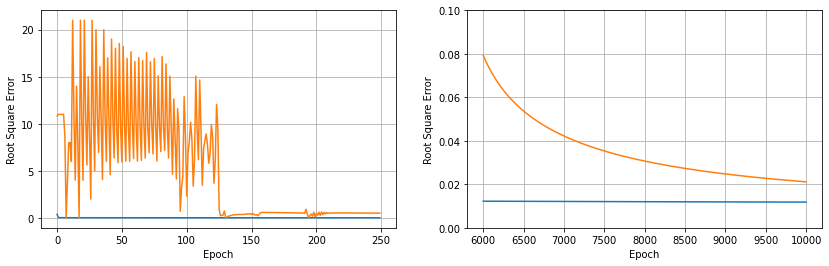

In [1411]:
fig = plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(np.sqrt(Error_S[0,:250]))
plt.plot(np.sqrt(Error_S[1,:250]))
plt.xlabel("Epoch")
plt.ylabel("Root Square Error")
plt.grid()
plt.subplot(122)
plt.plot(np.sqrt(Error_S[0,6000:]))
plt.plot(np.sqrt(Error_S[1,6000:]))
plt.ylim([0, 0.1])
plt.xlabel("Epoch")
plt.ylabel("Root Square Error")
plt.xticks(ticks=[i*500  for i in range(9)] , labels=[i*500 + 6000 for i in range(9)])
plt.grid()
plt.show()

# The spike outputs

> Here we feed the same image thatthe model trained by. The output must be the same as the label.

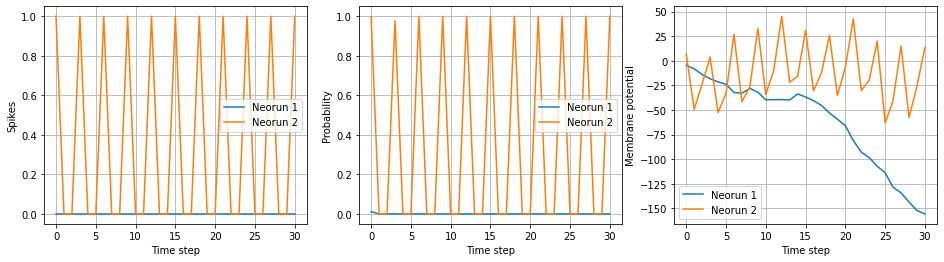

In [1416]:
n1 = network[0]
n2 = network[1]

fig = plt.figure(figsize=(16, 4))
plt.subplot(131)

plt.plot(n1.spikes(image), label="Neorun 1")
plt.plot(n2.spikes(image), label="Neorun 2")
plt.ylabel("Spikes")
plt.xlabel("Time step")
plt.legend()
plt.grid()

plt.subplot(132)
plt.plot(n1.probs(image), label="Neorun 1")
plt.plot(n2.probs(image), label="Neorun 2")
plt.ylabel("Probability")
plt.xlabel("Time step")
plt.legend()
plt.grid()

plt.subplot(133)
plt.plot(n1.memb(image), label="Neorun 1")
plt.plot(n2.memb(image), label="Neorun 2")
plt.ylabel("Membrane potential")
plt.xlabel("Time step")
plt.legend()
plt.grid()
plt.show()

# Plot the pre-synaptics weights 

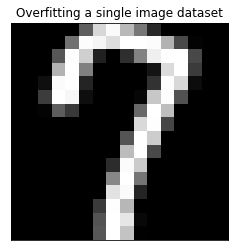

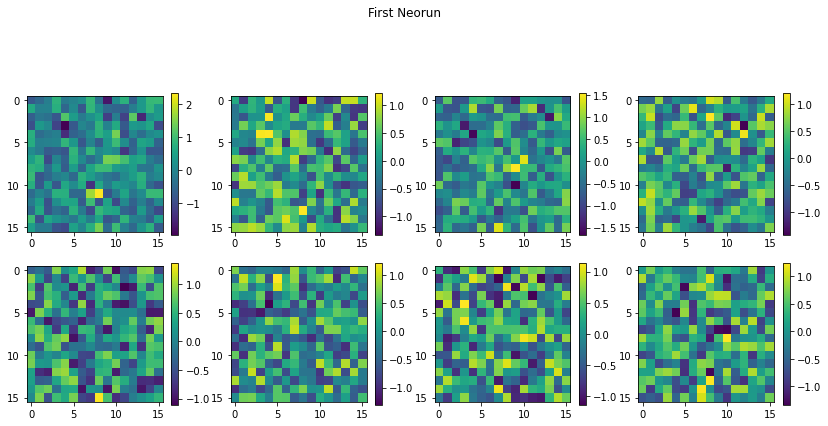

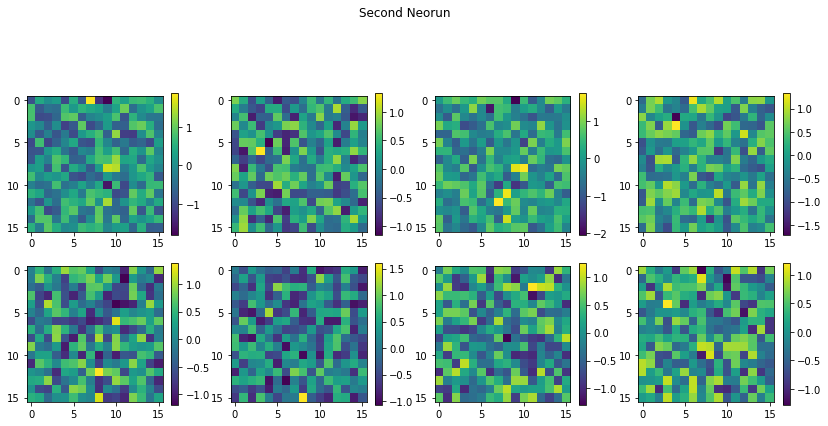

In [1393]:
plt.imshow(X_tr[3,:].reshape(16,16), interpolation='nearest', cmap='gray')
plt.title("Overfitting a single image dataset")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.show()

for j in [0,1]:
    fig = plt.figure(figsize=(14, 12))
    if j == 0: 
        plt.suptitle("First Neorun") 
    else:
        plt.suptitle("Second Neorun")
    
    gs=GridSpec(4,4)
    for i in range(8):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        plt.imshow(synaptic_ws_single[j,:,i].reshape((16,16)), interpolation='nearest')
        plt.colorbar()
    plt.show()

## Batch SGD, utilising multiprocessor architecture

In [1170]:
# lerning rate
etas = [0.3, 0.3]
# maximum epoch
epoch = 130
# batch size
batch_size = 100

global_errors = np.zeros((neuron_numbers, epoch))
# A single neuron finds it MLE gradiants
# over the batch
def parallel_learning(args):    
    labels = args[0]    
    images = args[1]
    neuron = args[2]
    eta = args[3]
    batch_len = images.shape[0]
    errors = np.zeros(batch_len)   
    for i in  range(batch_len):
        image = images[i, :, :]        
        label = labels[i, :]        
        _, errs = neuron.update(image, label, eta)
        errors[i] = np.sum(errs**2)
                
    return (neuron, errors)



image_indices = [image_index in range(train_size)]
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=43)

network = []
for i in range(neuron_numbers):
    network += [init_neuron(i)]

for epo in range(epoch):
    #if epo % 10 == 0:
    #    print(f"epoch={epo}")
    
    #shuffle the training set at the start of each epoch
    np.random.shuffle(image_indices)   
    errors = np.zeros(neuron_numbers)
    for i_start in range(0, train_size, batch_size):
        batch_indices = list(range(i_start, min(i_start+batch_size, train_size)))
        images = trainset[batch_indices, :, :]
        labels = train_y[:, batch_indices, :]           
        #params = [(labels[i, :, :], images, network[i], etas[i]/((epo//5)+1)) for i in range(output)] 
        params = [(labels[i, :, :], images, network[i], etas[i]/ np.sqrt(1 + 10*epo)) for i in range(output)] 
        #params = [(labels[i, :, :], images, network[i], etas[i]/ (1 + epo) for i in range(output)] 
         
        with Pool(neuron_numbers) as pool:
            parallel_result = pool.map(parallel_learning, params)
            
        for i in range(neuron_numbers):
            neuron, err = parallel_result[i]
            errors[i] = np.sum(err)
            network[i] = neuron
            
    global_errors[:, epo] = errors
            
    if epo % 10 == 0:
        print(epo, global_errors[:, epo])


0 [9917.29675353 3106.07149641]
10 [124.16351948 107.25094056]
20 [82.53791707 42.44948991]
30 [50.78791343 39.58332992]
40 [54.53350559 38.92668486]
50 [43.70221075 32.78905348]
60 [49.7085174  25.82655548]
70 [51.03416409 26.11227689]
80 [45.46596796 27.40899221]
90 [42.64783935 23.54371886]
100 [40.3780996  24.67998641]
110 [40.99085212 23.68527826]
120 [40.66774707 23.68280408]


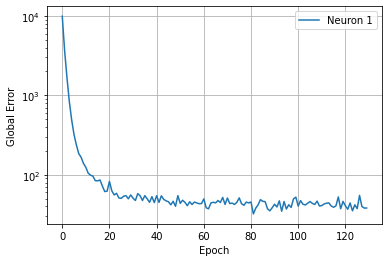

In [1171]:
plt.plot(np.abs(global_errors[0, :]), label="Neuron 1")
#plt.plot(np.abs(global_errors[1, :]), label="Neuron 2")
plt.xlabel("Epoch")
plt.ylabel("Global Error")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

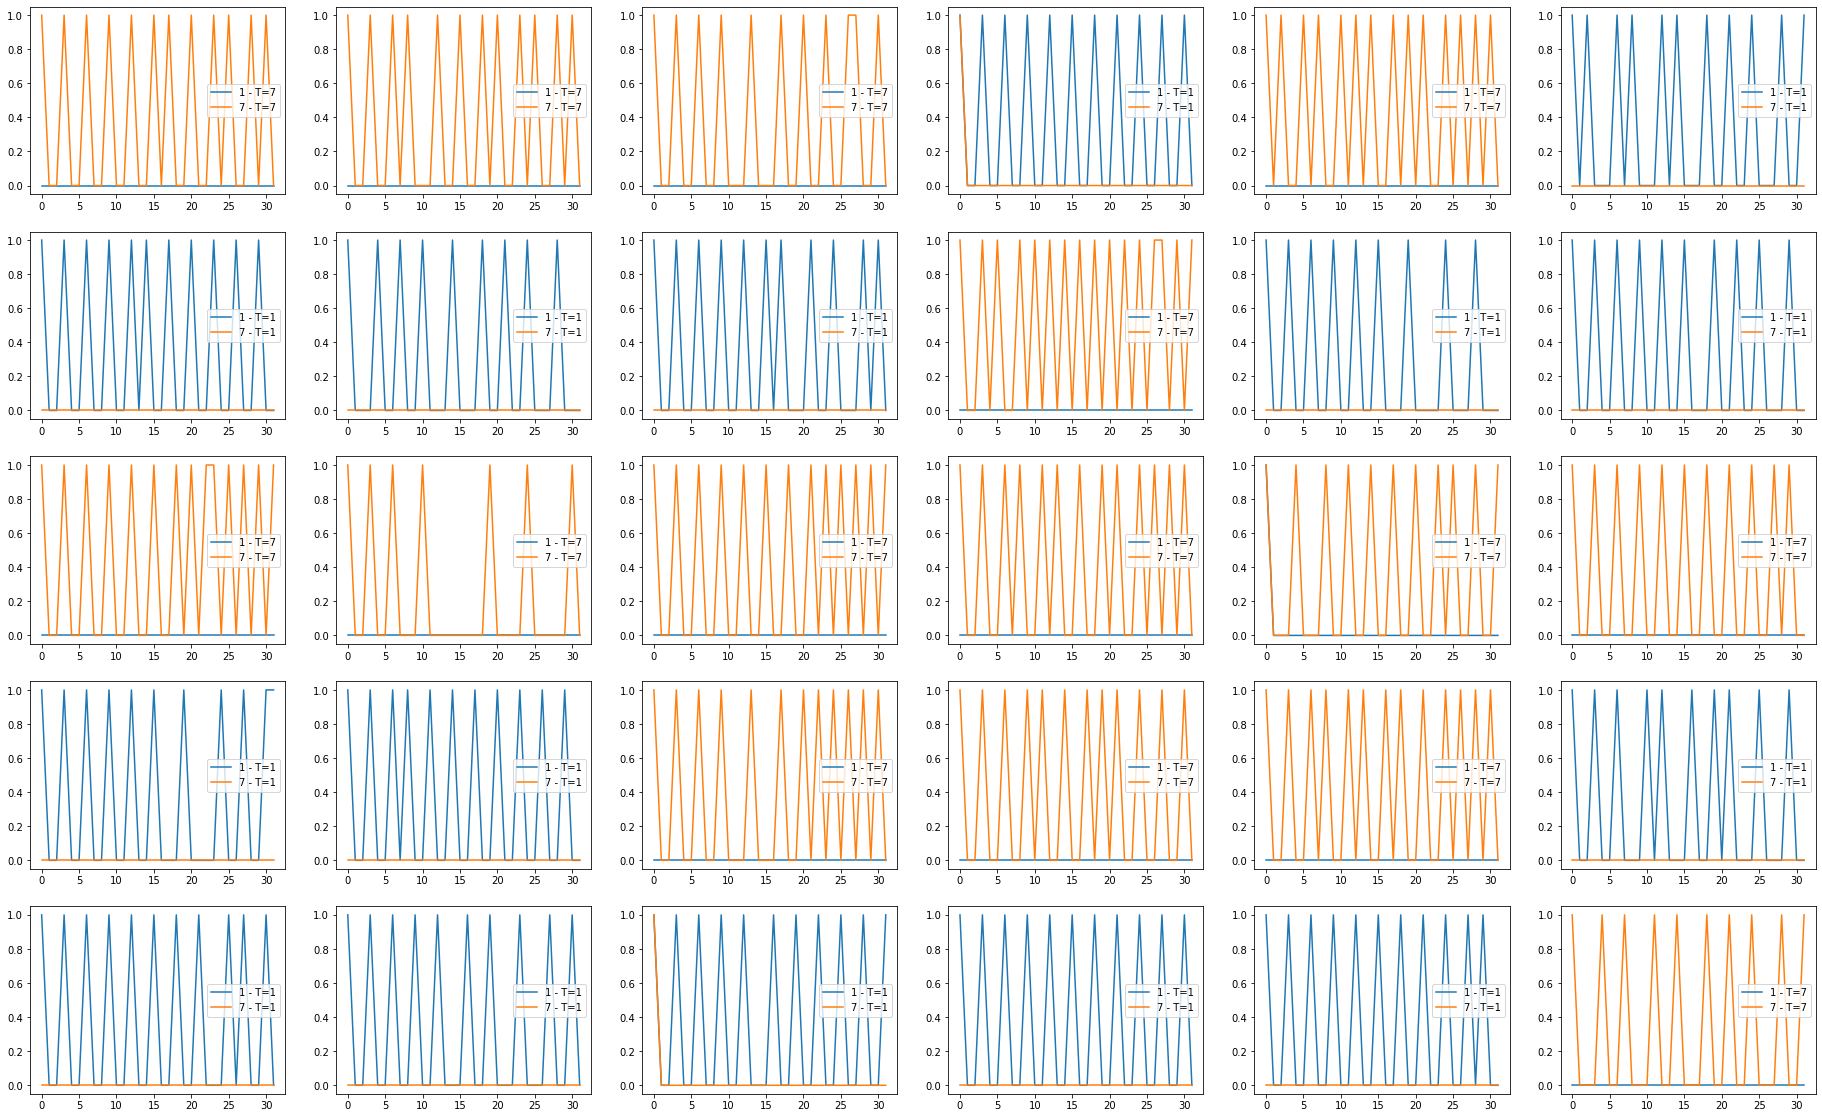

In [1172]:
n1 = network[0]
n2 = network[1]
fig = plt.figure(figsize=(32,20))

for i in range(5):
    for j in range(6):
        image_index = j + i*6 + 1 
        plt.subplot(5, 6, image_index)
        plt.plot(n1.spikes_f(testset[image_index,:,:]), label=f"1 - T={y2_te[image_index]}")
        plt.plot(n2.spikes_f(testset[image_index,:,:]), label=f"7 - T={y2_te[image_index]}")
        plt.legend()
plt.show()

In [1173]:

TP = 0
p = 1/Freq
for image_index in range(test_size):
    image  = testset[image_index,:,:]
    
    label = y2_te[image_index]
    pred_1 = np.mean(moving_average(n1.spikes_f(image), Freq))
    pred_2 = np.mean(moving_average(n2.spikes_f(image), Freq))
    #print(label, pred_1, pred_2)
    if np.abs(p - pred_1) < np.abs(p - pred_2) and label == 1:
        TP  += 1
    elif np.abs(p - pred_1) > np.abs(p - pred_2) and label == 7:
        TP  += 1
        
print(f"TP: {TP}, accuracy:{TP/test_size}")

TP: 124, accuracy:0.992


In [1176]:

TP = 0
p = 1/Freq
for image_index in range(test_size):
    image  = testset[image_index,:,:]
    
    label = y2_te[image_index]
    pred_1 = np.mean(n1.spikes_f(image))
    pred_2 = np.mean(n2.spikes_f(image))
    #print(label, pred_1, pred_2)
    if np.abs(p - pred_1) < np.abs(p - pred_2) and label == 1 and np.abs(p - pred_1) <.31:
        TP  += 1
    elif np.abs(p - pred_1) > np.abs(p - pred_2) and label == 7 and np.abs(p - pred_2) <.31:
        TP  += 1
        
print(f"TP: {TP}, accuracy:{TP/test_size}")

TP: 124, accuracy:0.992


In [1180]:
def init_ws_2(image_size, K, T, cosin_feedback = True, seed=44):
    if seed is not None:
        np.random.seed(seed)
    synaptic_ws = np.random.uniform(-1, 1, (output, image_size,  K))
    if cosin_feedback:
        feedback_ws = np.random.uniform(-1, 1, (output, K))
    else:
        feedback_ws = np.random.uniform(-1, 1, output)
        
    cross_feedback_ws = np.random.uniform(-1, 1, output)
    bias_paras = np.random.uniform(-1, 1, output)
    
    def init_neuron_cosine(i):
        '''Create a single neuron with
           inversed cosin basis for feedback
        '''
        return Neuron2(image_size, K, T, 
                      synaptic_ws[i,...], feedback_ws[i,:],cross_feedback_ws[i], bias_paras[i],                    
                      cosin_basis, -cosin_basis, exp_basis)
    
    def init_neuron_exp(i):
        '''Create a single neuron with
           exp basis for feedback
        '''
        return Neuron2(image_size, K, T, 
                      synaptic_ws[i,...], feedback_ws[i], cross_feedback_ws[i], bias_paras[i],                  
                      cosin_basis, exp_basis, exp_basis)
    if cosin_feedback:
        return init_neuron_cosine
    else:
        return init_neuron_exp

In [1241]:
init_neuron_2 = init_ws_2(image_size, K, T, cosin_feedback = False, seed=43)


image_index = 0

image = trainset[image_index, :, :]         
label = train_y[:, image_index, :] 

eta = 0.25
max_epoch = 300
Error_S = np.zeros((2, max_epoch))
network = [None, None]

neuron1 = init_neuron_2(0)
network[0] = neuron1
neuron2 = init_neuron_2(1)
network[1] = neuron2


for epo in range(max_epoch):
    
    spikes = [[0], [0]]
    
    for t in range(1, T):
        if t == 1:
            g_bias_1, g_synaptic_ws_1, g_feedback_ws_1, g_cross_feedback_ws_1, spikes_1 =  neuron1.gradiant(label[0, t-1], image, t, spikes[1])
        
            g_bias_2, g_synaptic_ws_2, g_feedback_ws_2, g_cross_feedback_ws_2, spikes_2 =  neuron2.gradiant(label[1, t-1], image, t, spikes[0])
        else:
            g_bias_12, g_synaptic_ws_12, g_feedback_ws_12, g_cross_feedback_ws_12, spikes_1 =  neuron1.gradiant(label[0, t-1], image, t, spikes[1])
            g_bias_1 += g_bias_12
            g_synaptic_ws_1 += g_synaptic_ws_12
            g_feedback_ws_1 += g_feedback_ws_12
            g_cross_feedback_ws_1 += g_cross_feedback_ws_12
            g_bias_22, g_synaptic_ws_22, g_feedback_ws_22, g_cross_feedback_ws_22, spikes_2 =  neuron2.gradiant(label[1, t-1], image, t, spikes[0])
            g_bias_2 += g_bias_22
            g_synaptic_ws_2 += g_synaptic_ws_22
            g_feedback_ws_2 += g_feedback_ws_22
            g_cross_feedback_ws_2 += g_cross_feedback_ws_22
        
        spikes = [spikes_1, spikes_2]

        Error_S[0, epo] += np.sum(g_bias_1**2)        
        Error_S[1, epo] += np.sum(g_bias_2**2)
        
    neuron1.gamma += eta*g_bias_1/(epo+1)
    neuron1.synaptic_ws += eta*g_synaptic_ws_1/(epo+1)
    neuron1.feedback_ws += eta*g_feedback_ws_1/(epo+1) 
    neuron1.cross_feedback_ws += eta*g_cross_feedback_ws_1/(epo+1) 

    neuron2.gamma += eta*g_bias_2/(epo+1)
    neuron2.synaptic_ws += eta*g_synaptic_ws_2/(epo+1)
    neuron2.feedback_ws += eta*g_feedback_ws_2/(epo+1) 
    neuron2.cross_feedback_ws += eta*g_cross_feedback_ws_2/(epo+1) 

    
    # Early stop
    if Error_S[i, epo] < 1e-2:
        #print(neuron.spikes(image))
        print(i, epo)            
        break
                

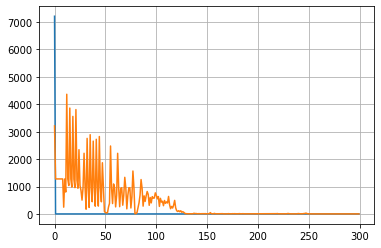

In [1242]:
plt.plot(Error_S[0,:])
plt.plot(Error_S[1,:])
plt.grid()
plt.show()

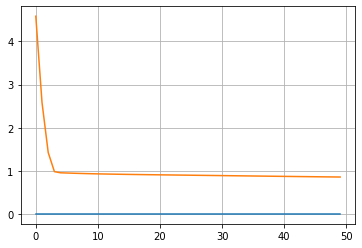

In [1244]:
plt.plot(Error_S[0,250:])
plt.plot(Error_S[1,250:])
plt.grid()
plt.show()